In [30]:
!conda install pytorch cpuonly -c pytorch -y

Solving environment: done

# All requested packages already installed.



In [32]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import MNIST
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [33]:
#Hyperparameter
batch_size = 128
learning_rate = .001

#other constants, image is 28 x 28 pixels
input_size = 28*28
output_classes = 10 # holds an array of probabily for digits from 0 to 9

In [7]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)


(tensor(1.), tensor(4., requires_grad=True), tensor(5., requires_grad=True))

In [83]:
len(dataset)

60000

In [84]:
# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000]) # training dataset, validation dataset split
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 9


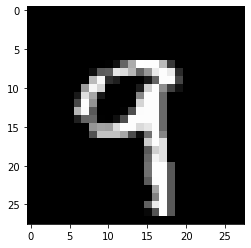

In [85]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [86]:
#Model
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_classes)
        
    def forward(self,xb):
        xb = xb.reshape(-1,784) # -1 so rows can take any number, and columns 28*28
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()
        

In [87]:
#Training
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)# index and the highest probability in output class vector
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [88]:
#evaluate the model using the validation set
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [89]:
#fit the model, Stocastic Gradient descent where the looped through nultiple epochs to calculate 
#the gradient using weight and bias to decrease the loss, improve the model at every iteration by a small amout that is the learning rate
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [90]:
evaluate(model, val_loader)

{'val_loss': 2.3088197708129883, 'val_acc': 0.10380859673023224}

In [91]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 2.308178663253784, 'val_acc': 0.10439453274011612}

In [92]:
history = fit(5, 0.001, model, train_loader, val_loader)

Epoch: 0, val_loss: 1.9501, val_acc: 0.5968
Epoch: 1, val_loss: 1.6829, val_acc: 0.7108
Epoch: 2, val_loss: 1.4840, val_acc: 0.7522
Epoch: 3, val_loss: 1.3340, val_acc: 0.7711
Epoch: 4, val_loss: 1.2186, val_acc: 0.7849


In [93]:
accuracy = [r['val_acc'] for r in history]
print(accuracy)

[0.5967773199081421, 0.7108398675918579, 0.752246081829071, 0.7710937261581421, 0.784863293170929]


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

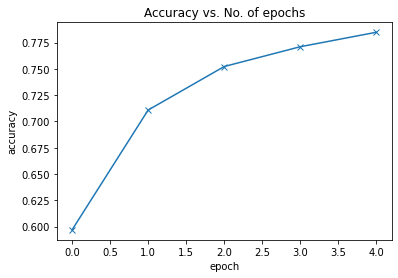

In [94]:
plt.plot(accuracy,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [95]:
#predictions
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


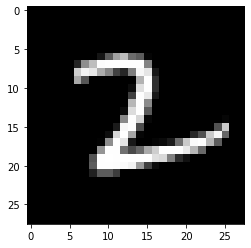

In [96]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [97]:
#save and upload
torch.save(model.state_dict(), 'mnist-logistic.pth')